In [1]:
from deepset import *
MODEL = DeepSet(in_features=5, feats=[80,120,70,50,8], n_class=2,pool="mean") #for full dataset Mean pooling, for small dataset Max pooling
model=MODEL
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device) 


pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean


In [2]:
import torch
from torch.utils.data import Dataset
import pickle
import os
import numpy as np
import random
import pandas as pd

class StreamingHcaDataset(Dataset): 
    def __init__(self, proton_dir, pion_dir, features=["x", "y", "z", "total_energy", "mean_time"]):
        super().__init__()
        
        self.proton_files = sorted([os.path.join(proton_dir, f) for f in os.listdir(proton_dir) if f.endswith(".pkl")])
        self.pion_files = sorted([os.path.join(pion_dir, f) for f in os.listdir(pion_dir) if f.endswith(".pkl")])

        self.features = features
        self.all_files = self.proton_files + self.pion_files  # Combine file lists
        self.labels = [0] * len(self.proton_files) + [1] * len(self.pion_files)  # 0 for proton, 1 for pion

    def __len__(self):
        return len(self.all_files)  # Total number of files

    def _load_file(self, file_path, label):
        """Loads a single pickle file (containing a single DataFrame) and returns point cloud data with labels."""
        # with open(file_path, "rb") as f:
        #     df = pickle.load(f)  # Load single DataFrame
    
        df=pd.read_pickle(file_path)
        # df=pd.read_parquet(file_path,engine='fastparquet')
        df=df[df["total_energy"]>5]
        
          
        part_feat = df[self.features].to_numpy()

        # Handle NaN and Inf values
        part_feat[np.isnan(part_feat)] = 0.0
        part_feat[np.isinf(part_feat)] = 0.0

        return {
            "part": torch.tensor(part_feat, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "seq_length": torch.tensor(part_feat.shape[0], dtype=torch.long),
        }

    def __getitem__(self, idx):
        random_idx = random.randint(0, len(self.all_files) - 1)  # Pick a random file
        file_path = self.all_files[random_idx]
        label = self.labels[random_idx]

        return self._load_file(file_path, label)  # Return data from the chosen file


In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Custom collate function to handle variable-length point cloud data."""
    parts = [item["part"] for item in batch]  # List of tensors (each of shape [N, 5])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)  # Convert list to tensor
    seq_lengths = torch.tensor([item["seq_length"] for item in batch], dtype=torch.long)  # Convert list to tensor

    # Pad variable-length tensors to the longest sequence in the batch
    padded_parts = pad_sequence(parts, batch_first=True, padding_value=0.0)  # Shape [batch_size, max_seq_len, 5]

    return {"part": padded_parts, "label": labels, "seq_length": seq_lengths}


In [ ]:

pion_dir ="/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_pion_25GeV_50"
proton_dir ="/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_proton_25GeV_50"
name=proton_dir.replace("/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_proton_","")
print(name)
from torch.utils.data import random_split, DataLoader

# Define dataset
train_dataset = StreamingHcaDataset(proton_dir=proton_dir, pion_dir=pion_dir)

# Define split sizes
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum matches total_size

# Split dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=32)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)


print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")



25GeV_200
Train: 160000, Validation: 20000, Test: 20000


In [5]:
import tqdm
def test_model(model, test_loader, criterion=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    correct = 0
    total_samples = 0

    # Progress bar for testing
    test_loader_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    with torch.no_grad():
        for i,batch in test_loader_tqdm:
            parts = batch["part"].to(device)         # Input point cloud data
            labels = batch["label"].to(device)  # Labels
            batch_size,seq_len,feat_dim=parts.shape
            parts=parts.cpu().numpy().reshape(-1,feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts=torch.tensor(parts).reshape(batch_size,seq_len,feat_dim).to(device)

            outputs = model(parts)  # Forward pass
            loss = criterion(outputs, labels) if criterion else 0  # Compute loss if provided
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            test_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar

    avg_loss = total_loss / len(test_loader) if criterion else 0
    accuracy = correct / total_samples * 100

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss , accuracy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

def train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=5e-4, device=None, save_path=f"./Models/Z_{name}.pth", log_path=f"./Logs/log_summary_Z_{name}.csv"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")  # Initialize best loss

    log_data = []  # To store log info for CSV

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, batch in train_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts = parts.cpu().numpy().reshape(-1, feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts = torch.tensor(parts).reshape(batch_size, seq_len, feat_dim).float().to(device)

            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(parts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        val_loss, Accuracy = test_model(model, val_loader, criterion, device)
         

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save log
        log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": avg_train_loss,
            "Val Loss": val_loss,
            "Accuracy": Accuracy,  # Placeholder for accuracy
        })

        # Save model if validation improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    # Save the log to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(log_path, index=False)
    print(f"Training log saved to {log_path}")
    print("Training complete!")


In [7]:

if __name__ == "__main__":
    #Train the model
    train_model(model, train_loader,val_loader=val_loader, num_epochs=60, learning_rate=5e-4, device=device)

Testing: 100%|██████████| 625/625 [00:20<00:00, 30.06it/s, loss=0.501]


Test Loss: 0.5555, Accuracy: 71.60%
Epoch [1/60], Train Loss: 0.6123, Val Loss: 0.5555
Model saved at epoch 1 with val loss 0.5555


Testing: 100%|██████████| 625/625 [00:26<00:00, 23.17it/s, loss=0.366]


Test Loss: 0.4444, Accuracy: 78.17%
Epoch [2/60], Train Loss: 0.4900, Val Loss: 0.4444
Model saved at epoch 2 with val loss 0.4444


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.79it/s, loss=0.493]


Test Loss: 0.4368, Accuracy: 79.14%
Epoch [3/60], Train Loss: 0.4431, Val Loss: 0.4368
Model saved at epoch 3 with val loss 0.4368


Testing: 100%|██████████| 625/625 [00:20<00:00, 31.03it/s, loss=0.718]

Test Loss: 0.5216, Accuracy: 73.81%
Epoch [4/60], Train Loss: 0.4242, Val Loss: 0.5216



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.30it/s, loss=0.376]


Test Loss: 0.4223, Accuracy: 80.23%
Epoch [5/60], Train Loss: 0.4162, Val Loss: 0.4223
Model saved at epoch 5 with val loss 0.4223


Testing: 100%|██████████| 625/625 [00:21<00:00, 28.88it/s, loss=0.359]


Test Loss: 0.3986, Accuracy: 81.31%
Epoch [6/60], Train Loss: 0.4072, Val Loss: 0.3986
Model saved at epoch 6 with val loss 0.3986


Testing: 100%|██████████| 625/625 [00:21<00:00, 29.26it/s, loss=0.517]

Test Loss: 0.4098, Accuracy: 80.27%
Epoch [7/60], Train Loss: 0.3984, Val Loss: 0.4098



Testing: 100%|██████████| 625/625 [00:21<00:00, 28.79it/s, loss=0.548]

Test Loss: 0.4232, Accuracy: 79.75%
Epoch [8/60], Train Loss: 0.3951, Val Loss: 0.4232



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.73it/s, loss=0.316]


Test Loss: 0.3812, Accuracy: 82.22%
Epoch [9/60], Train Loss: 0.3925, Val Loss: 0.3812
Model saved at epoch 9 with val loss 0.3812


Testing: 100%|██████████| 625/625 [00:26<00:00, 23.39it/s, loss=0.477]


Test Loss: 0.3787, Accuracy: 81.98%
Epoch [10/60], Train Loss: 0.3867, Val Loss: 0.3787
Model saved at epoch 10 with val loss 0.3787


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.15it/s, loss=0.186]


Test Loss: 0.3784, Accuracy: 82.45%
Epoch [11/60], Train Loss: 0.3857, Val Loss: 0.3784
Model saved at epoch 11 with val loss 0.3784


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.85it/s, loss=0.334]

Test Loss: 0.3899, Accuracy: 81.39%
Epoch [12/60], Train Loss: 0.3816, Val Loss: 0.3899



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.92it/s, loss=0.554]

Test Loss: 0.4031, Accuracy: 80.48%
Epoch [13/60], Train Loss: 0.3791, Val Loss: 0.4031



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.16it/s, loss=0.499]


Test Loss: 0.3648, Accuracy: 83.03%
Epoch [14/60], Train Loss: 0.3788, Val Loss: 0.3648
Model saved at epoch 14 with val loss 0.3648


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.94it/s, loss=0.471]

Test Loss: 0.3671, Accuracy: 82.88%
Epoch [15/60], Train Loss: 0.3748, Val Loss: 0.3671



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.56it/s, loss=0.571]

Test Loss: 0.3655, Accuracy: 83.07%
Epoch [16/60], Train Loss: 0.3748, Val Loss: 0.3655



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.22it/s, loss=0.471]

Test Loss: 0.3717, Accuracy: 82.98%
Epoch [17/60], Train Loss: 0.3702, Val Loss: 0.3717



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.31it/s, loss=0.406]

Test Loss: 0.3992, Accuracy: 81.10%
Epoch [18/60], Train Loss: 0.3706, Val Loss: 0.3992



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.43it/s, loss=0.373]

Test Loss: 0.3706, Accuracy: 82.84%
Epoch [19/60], Train Loss: 0.3690, Val Loss: 0.3706



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.10it/s, loss=0.377]


Test Loss: 0.3614, Accuracy: 83.36%
Epoch [20/60], Train Loss: 0.3686, Val Loss: 0.3614
Model saved at epoch 20 with val loss 0.3614


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.13it/s, loss=0.571]

Test Loss: 0.3758, Accuracy: 82.31%
Epoch [21/60], Train Loss: 0.3668, Val Loss: 0.3758



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.10it/s, loss=0.314]


Test Loss: 0.3587, Accuracy: 83.22%
Epoch [22/60], Train Loss: 0.3652, Val Loss: 0.3587
Model saved at epoch 22 with val loss 0.3587


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.41it/s, loss=0.239]


Test Loss: 0.3546, Accuracy: 83.97%
Epoch [23/60], Train Loss: 0.3646, Val Loss: 0.3546
Model saved at epoch 23 with val loss 0.3546


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.26it/s, loss=0.225]

Test Loss: 0.3757, Accuracy: 82.05%
Epoch [24/60], Train Loss: 0.3640, Val Loss: 0.3757



Testing: 100%|██████████| 625/625 [00:24<00:00, 25.28it/s, loss=0.591]

Test Loss: 0.3698, Accuracy: 82.69%
Epoch [25/60], Train Loss: 0.3592, Val Loss: 0.3698



Testing: 100%|██████████| 625/625 [00:24<00:00, 25.64it/s, loss=0.418]

Test Loss: 0.3594, Accuracy: 83.33%
Epoch [26/60], Train Loss: 0.3580, Val Loss: 0.3594



Testing: 100%|██████████| 625/625 [00:24<00:00, 25.32it/s, loss=0.389]

Test Loss: 0.3710, Accuracy: 82.92%
Epoch [27/60], Train Loss: 0.3626, Val Loss: 0.3710



Testing: 100%|██████████| 625/625 [00:24<00:00, 25.78it/s, loss=0.372]


Test Loss: 0.3541, Accuracy: 83.73%
Epoch [28/60], Train Loss: 0.3576, Val Loss: 0.3541
Model saved at epoch 28 with val loss 0.3541


Testing: 100%|██████████| 625/625 [00:24<00:00, 25.45it/s, loss=0.459]


Test Loss: 0.3416, Accuracy: 84.44%
Epoch [29/60], Train Loss: 0.3589, Val Loss: 0.3416
Model saved at epoch 29 with val loss 0.3416


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.14it/s, loss=0.269]

Test Loss: 0.3578, Accuracy: 83.35%
Epoch [30/60], Train Loss: 0.3558, Val Loss: 0.3578



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.28it/s, loss=0.349]

Test Loss: 0.3651, Accuracy: 82.66%
Epoch [31/60], Train Loss: 0.3571, Val Loss: 0.3651



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.22it/s, loss=0.439]


Test Loss: 0.3466, Accuracy: 83.71%
Epoch [32/60], Train Loss: 0.3527, Val Loss: 0.3466


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.90it/s, loss=0.586]

Test Loss: 0.3478, Accuracy: 83.81%
Epoch [33/60], Train Loss: 0.3521, Val Loss: 0.3478



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.81it/s, loss=0.497]

Test Loss: 0.3627, Accuracy: 83.10%
Epoch [34/60], Train Loss: 0.3552, Val Loss: 0.3627



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.72it/s, loss=0.461]

Test Loss: 0.3429, Accuracy: 83.98%
Epoch [35/60], Train Loss: 0.3515, Val Loss: 0.3429



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.68it/s, loss=0.234]

Test Loss: 0.3420, Accuracy: 84.03%
Epoch [36/60], Train Loss: 0.3508, Val Loss: 0.3420



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.22it/s, loss=0.281]

Test Loss: 0.3552, Accuracy: 83.23%
Epoch [37/60], Train Loss: 0.3518, Val Loss: 0.3552



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.56it/s, loss=0.254]

Test Loss: 0.3467, Accuracy: 83.61%
Epoch [38/60], Train Loss: 0.3512, Val Loss: 0.3467



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.18it/s, loss=0.406]

Test Loss: 0.3516, Accuracy: 84.01%
Epoch [39/60], Train Loss: 0.3485, Val Loss: 0.3516



Testing: 100%|██████████| 625/625 [00:23<00:00, 27.00it/s, loss=0.426]

Test Loss: 0.3454, Accuracy: 83.63%
Epoch [40/60], Train Loss: 0.3500, Val Loss: 0.3454



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.70it/s, loss=0.323] 


Test Loss: 0.3383, Accuracy: 84.52%
Epoch [41/60], Train Loss: 0.3473, Val Loss: 0.3383
Model saved at epoch 41 with val loss 0.3383


Testing: 100%|██████████| 625/625 [00:23<00:00, 26.57it/s, loss=0.424]


Test Loss: 0.3371, Accuracy: 84.41%
Epoch [42/60], Train Loss: 0.3504, Val Loss: 0.3371
Model saved at epoch 42 with val loss 0.3371


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.82it/s, loss=0.406]

Test Loss: 0.3730, Accuracy: 82.80%
Epoch [43/60], Train Loss: 0.3485, Val Loss: 0.3730



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.60it/s, loss=0.388] 

Test Loss: 0.3626, Accuracy: 83.16%
Epoch [44/60], Train Loss: 0.3476, Val Loss: 0.3626



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.22it/s, loss=0.25] 


Test Loss: 0.3364, Accuracy: 84.52%
Epoch [45/60], Train Loss: 0.3477, Val Loss: 0.3364
Model saved at epoch 45 with val loss 0.3364


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.99it/s, loss=0.301]

Test Loss: 0.3528, Accuracy: 83.60%
Epoch [46/60], Train Loss: 0.3465, Val Loss: 0.3528



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.70it/s, loss=0.317]

Test Loss: 0.3419, Accuracy: 84.25%
Epoch [47/60], Train Loss: 0.3464, Val Loss: 0.3419



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.98it/s, loss=0.256]


Test Loss: 0.3407, Accuracy: 84.19%
Epoch [48/60], Train Loss: 0.3447, Val Loss: 0.3407


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.37it/s, loss=0.382]

Test Loss: 0.3377, Accuracy: 84.78%
Epoch [49/60], Train Loss: 0.3460, Val Loss: 0.3377



Testing: 100%|██████████| 625/625 [00:23<00:00, 26.40it/s, loss=0.631]

Test Loss: 0.3520, Accuracy: 83.32%
Epoch [50/60], Train Loss: 0.3460, Val Loss: 0.3520



Testing: 100%|██████████| 625/625 [00:22<00:00, 28.24it/s, loss=0.474]


Test Loss: 0.3346, Accuracy: 84.47%
Epoch [51/60], Train Loss: 0.3445, Val Loss: 0.3346
Model saved at epoch 51 with val loss 0.3346


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.93it/s, loss=0.375]

Test Loss: 0.3432, Accuracy: 84.25%
Epoch [52/60], Train Loss: 0.3441, Val Loss: 0.3432



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.54it/s, loss=0.308]


Test Loss: 0.3386, Accuracy: 84.41%
Epoch [53/60], Train Loss: 0.3435, Val Loss: 0.3386


Testing: 100%|██████████| 625/625 [00:21<00:00, 28.45it/s, loss=0.351]


Test Loss: 0.3337, Accuracy: 84.58%
Epoch [54/60], Train Loss: 0.3420, Val Loss: 0.3337
Model saved at epoch 54 with val loss 0.3337


Testing: 100%|██████████| 625/625 [00:22<00:00, 28.27it/s, loss=0.421]

Test Loss: 0.3425, Accuracy: 83.92%
Epoch [55/60], Train Loss: 0.3420, Val Loss: 0.3425



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.31it/s, loss=0.435]


Test Loss: 0.3312, Accuracy: 84.67%
Epoch [56/60], Train Loss: 0.3430, Val Loss: 0.3312
Model saved at epoch 56 with val loss 0.3312


Testing: 100%|██████████| 625/625 [00:20<00:00, 30.78it/s, loss=0.372]

Test Loss: 0.3359, Accuracy: 84.47%
Epoch [57/60], Train Loss: 0.3419, Val Loss: 0.3359



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.36it/s, loss=0.331]

Test Loss: 0.3567, Accuracy: 83.34%
Epoch [58/60], Train Loss: 0.3404, Val Loss: 0.3567



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.06it/s, loss=0.279]


Test Loss: 0.3284, Accuracy: 84.81%
Epoch [59/60], Train Loss: 0.3386, Val Loss: 0.3284
Model saved at epoch 59 with val loss 0.3284


Testing: 100%|██████████| 625/625 [00:20<00:00, 30.69it/s, loss=0.396]


Test Loss: 0.3419, Accuracy: 84.14%
Epoch [60/60], Train Loss: 0.3395, Val Loss: 0.3419
Training log saved to ./Logs/log_summary_Z_25GeV_200.csv
Training complete!


In [8]:
model_test = MODEL
model_name=f"./Models/Z_{name}.pth"
print(model_name)
model_test.load_state_dict(torch.load(f"./Models/Z_{name}.pth",weights_only=True))
model_test.to(device)

./Models/Z_25GeV_200.pth


DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=5, out_features=80, bias=True)
      (Lambda): Linear(in_features=5, out_features=80, bias=True)
      (bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=80, out_features=120, bias=True)
      (Lambda): Linear(in_features=80, out_features=120, bias=True)
      (bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=120, out_features=70, bias=True)
      (Lambda): Linear(in_features=120, out_features=70, bias=True)
      (bn): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=70, out_features=5

In [9]:
total_params = sum(p.numel() for p in MODEL.parameters())
print(total_params)

45292


In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import beta

def evaluate_model(model, data_loader, criterion, device, name1="model", return_accuracy=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    data_loader_tqdm = tqdm(enumerate(data_loader), desc="Testing", total=len(data_loader))
    
    true_labels = []
    pred_labels = []
    all_scores = []

    with torch.no_grad():
        for i, batch in data_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts_np = parts.cpu().numpy().reshape(-1, feat_dim)

            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts_np = qt.fit_transform(parts_np)
            parts = torch.tensor(parts_np).reshape(batch_size, seq_len, feat_dim).to(device)

            labels = batch["label"].to(device)
            outputs = model(parts)
            preds = F.softmax(outputs, dim=1)

            # Collect soft scores for the positive class (class 1)
            all_scores.extend(preds[:, 1].detach().cpu().numpy())
            pred_labels.extend(torch.argmax(preds, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if return_accuracy:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total if return_accuracy else None

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    colors = ["#cce5ff", "#004c99"]
    cmap = LinearSegmentedColormap.from_list("Custom Blue", colors)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Proton", "Pion"], yticklabels=["Proton", "Pion"],
                annot_kws={"size": 18, "weight": "bold"})
    
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]
    n_total = TP + TN + FP + FN
    n_correct = TP + TN
    alpha = 0.32

    lower_bound = beta.ppf(alpha / 2, n_correct, n_total - n_correct + 1)
    upper_bound = beta.ppf(1 - alpha / 2, n_correct + 1, n_total - n_correct)
    
    title = f"Accuracy: {accuracy:.2f}%, 68% CI: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]"
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel('Predicted', size=14, weight='bold')
    plt.ylabel('True', size=14, weight='bold')
    plt.xticks(size=14, weight='bold')
    plt.yticks(size=14, weight='bold')
    print(f"./Plots/confusion_matrix_{name}.pdf")
    plt.savefig(f"./Plots/confusion_matrix_{name}.pdf", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Confusion Matrix:\n{cm}")
    print(f"68% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

    # ROC Curve
    y_true = np.array(true_labels)
    y_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    N_x = sum(y_true == 0)
    N_y = sum(y_true == 1)
    sigma_fpr = np.sqrt(fpr * (1 - fpr) / N_x)
    sigma_tpr = np.sqrt(tpr * (1 - tpr) / N_y)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.fill_between(fpr, tpr - 5 * sigma_tpr, tpr + 5 * sigma_tpr,
                     color='blue', alpha=0.25, label='1-sigma region (PiPR) [5x]')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (Proton)', fontsize=12)
    plt.ylabel('True Positive Rate (Pion)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(f"./Plots/roc_curve_{name}.pdf")

    return (avg_loss, f"{accuracy:.2f}%") if return_accuracy else avg_loss



In [14]:
!pwd

/mnt/e/ML_PointCloud


Testing: 100%|██████████| 625/625 [00:21<00:00, 29.05it/s]


./Plots/confusion_matrix_25GeV_200.pdf
Confusion Matrix:
[[8169 1684]
 [1389 8758]]
68% Confidence Interval: [0.8438, 0.8489]


(0.33468992462158204, '84.64%')

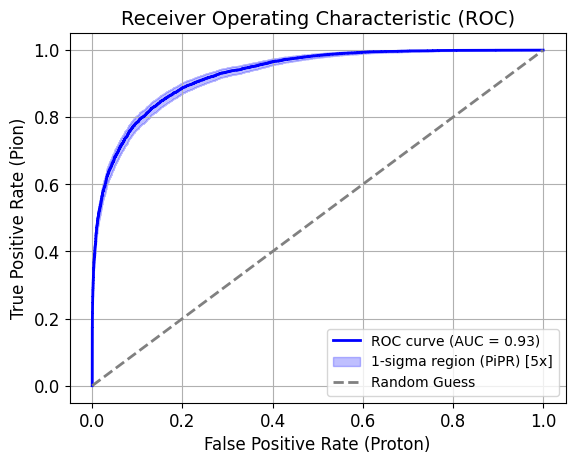

In [23]:
evaluate_model(model_test, test_loader, nn.CrossEntropyLoss(), device, return_accuracy=True)